<a href="https://colab.research.google.com/github/nvarasp/Project_IRWA/blob/main/RQ3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Link Analysis

## 0 - Imports and Setup

In [1]:
%%time
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_FILENAME = "/content/drive/My Drive/IRWA/FinalProject/data/tweets_covid_collected.json"
INPUT_FILENAME= "/content/drive/My Drive/IRWA/FinalProject/data/tweets_covid.json"
#save_json="/content/drive/My Drive/IRWA/FinalProject/notebook/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CPU times: user 245 µs, sys: 0 ns, total: 245 µs
Wall time: 1.46 ms


In [2]:
%%capture
!pip install config

In [3]:
!pip install implicit

In [4]:
!pip install cairocffi

In [5]:
!pip install python-igraph

In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import datetime
import time

# Import necessary libraries for graphs
from igraph import *
import numpy as np
import functools 
import igraph
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from collections import Counter
import implicit
from sklearn.model_selection import train_test_split
import random

###0.1 - Read the tweets file

In [7]:
with open(INPUT_FILENAME, "rb") as f:
    data = f.readlines()
    data = [json.loads(str_) for str_ in data]

Then, we inspect our data.

In [8]:
df_tweets = pd.DataFrame.from_records(data)
df_tweets.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,withheld_in_countries
0,Wed Nov 18 10:19:01 +0000 2020,1329006187384279042,1329006187384279042,"With the pressures of Brexit &amp; COVID-19, i...",False,"[0, 237]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1329006184850989058, 'id_str...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,None,NaN,None,None,"{'id': 867655190, 'id_str': '867655190', 'name...",None,None,None,None,False,0,0,False,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,Wed Nov 18 10:19:01 +0000 2020,1329006187535163392,1329006187535163392,RT @koshersemite: It’s coronavirus’s first bir...,False,"[0, 101]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1328912184689250305, 'id_str...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 285865405, 'id_str': '285865405', 'name...",None,None,None,None,False,29,0,False,False,False,en,{'created_at': 'Wed Nov 18 04:05:30 +0000 2020...,NaN,NaN,NaN,NaN,NaN
2,Wed Nov 18 10:19:01 +0000 2020,1329006187707199488,1329006187707199488,RT @Pollytics: Just a reminder that all of Aus...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 1014500145776349184, 'id_str': '1014500...",None,None,None,None,False,224,0,False,False,NaN,en,{'created_at': 'Wed Nov 18 06:23:43 +0000 2020...,NaN,NaN,NaN,NaN,NaN
3,Wed Nov 18 10:19:01 +0000 2020,1329006188248379392,1329006188248379392,RT @zerohedge: UK MP Suggests People Shouldn't...,False,"[0, 111]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 1092357811604983809, 'id_str': '1092357...",None,None,None,None,False,94,0,False,False,False,en,{'created_at': 'Wed Nov 18 07:00:01 +0000 2020...,NaN,NaN,NaN,NaN,NaN
4,Wed Nov 18 10:19:01 +0000 2020,1329006188697169921,1329006188697169921,RT @RandPaul: Why does the left accept immune ...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 385944134, 'id_str': '385944134', 'name...",None,None,None,None,False,2143,0,False,False,NaN,en,{'created_at': 'Tue Nov 17 19:56:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN


In [9]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55859 entries, 0 to 55858
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 55859 non-null  object 
 1   id                         55859 non-null  int64  
 2   id_str                     55859 non-null  object 
 3   full_text                  55859 non-null  object 
 4   truncated                  55859 non-null  bool   
 5   display_text_range         55859 non-null  object 
 6   entities                   55859 non-null  object 
 7   extended_entities          7642 non-null   object 
 8   source                     55859 non-null  object 
 9   in_reply_to_status_id      4070 non-null   float64
 10  in_reply_to_status_id_str  4070 non-null   object 
 11  in_reply_to_user_id        4477 non-null   float64
 12  in_reply_to_user_id_str    4477 non-null   object 
 13  in_reply_to_screen_name    4477 non-null   obj

## 1 - Retweet Graph
From the downloaded tweets, generate the retweet graph. The directed final graph G = (V,E) is constituted by all the users retweeting at least once, and a generic edge (u,v) means that users u retweeted at least once a tweet posted by the user v. In this part, we’ll test some contact recommendation algorithms to predict next retweets.


In [10]:
def get_user_and_retweeted_user(tweet_entry):
  if str(tweet_entry['retweeted_status']) != 'nan':

    #Take user and retweeted user
    user = tweet_entry['user']
    rt_user = tweet_entry['retweeted_status']

    #Crate two lists: one that specifies the user of the tweet(from_user) and the other the user that retweeted (to_user)
    from_user = user['id_str']
    to_user = rt_user['user']['id_str']
    followers = rt_user['user']['followers_count']
    return from_user, to_user, followers
    
  else:
    return None,None,None

Add to the original dataframe the new created columns

In [11]:
df_tweets['from_user'], df_tweets['to_user'], df_tweets['followers'] = zip(*df_tweets.apply(lambda x:get_user_and_retweeted_user(x), axis=1))

Create a dictionary just taking the from and to users

In [12]:
retweets_df = df_tweets[['to_user', 'from_user']]
edges = retweets_df.groupby('from_user')['to_user'].apply(list).to_dict()
first5edges = {k: edges[k] for k in list(edges)[:5]}
first5edges

{'1000100240777793543': ['18160106'],
 '1000131232234115072': ['125346858'],
 '1000165790803410946': ['195271137'],
 '1000172296097685504': ['956476343872454656'],
 '1000193665975779328': ['195271137']}

Use the previous mappings to create the edges of the graph

In [13]:
def network_mapping(network):
  mapping = {}
  entries = 0
  for key, value in network.items():
    if key not in mapping:
      mapping[key] = entries
      entries+=1
    for v in value:
      if v not in mapping:
        mapping[v] = entries
        entries+=1

  return mapping, entries

In [14]:
map, nodes = network_mapping(edges)

In [15]:
g = Graph(directed=False)
g.add_vertices(nodes)
g.add_edges([map[u], map[v]] for u in edges.keys() for v in edges[u])
g.is_directed()

False

Plot the graph through a log-log plot, where on x-axis we find a degree value d and on the y the number of nodes having such degree

In [16]:
def plot_loglog(degree_lst):
    """
    starting from a list of degrees, it plots the log-log
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # x is the degree, y the count
    degrees_distribution = Counter(degree_lst)
    
    # distinct degree 
    degrees_ = []
    # number of nodes having same degree
    count_ = []
    for d in degrees_distribution:
        
        # append both info, key and values
        degrees_.append(d)
        count_.append(degrees_distribution[d])
        
    # logarithmic scale of both axis
    x = np.log10(np.array(degrees_)+1)

    y = np.log10(np.array(count_)+1)
    
    # plot
    ax.scatter(x=x,y=y, alpha=0.5)
    
    plt.xlabel("Degree")
    plt.ylabel("Freq")
    plt.grid()
    plt.show()

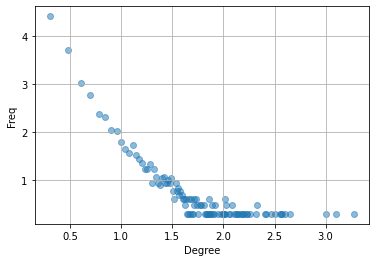

In [17]:
plot_loglog(g.degree())

In [18]:
g.pagerank(0)

2.0278697781060737e-05

## 2 - Split edges in train/test
Where the test is given by the 20% of the edges of the graph. These edges are sampling by random from the whole edgelist.

To create the test we need to sample a fraction p = 0.2 of the exististing edges in the graph. For do it we look at the edgelist and sample *p x N* nodes (being *N* the lenght of the graph) .

In [64]:
# fraction of edges to select as test-set
p = 0.2

# graphsize
N = len(g.es)

# idxs of all the edges
all_idxs = range(N)

# sample idxs of edges through the function "choice"
test_idxs = np.random.choice(all_idxs, size=int(p*N), replace=False)

We know need to select the edges scrolling in the edgelist

In [20]:
ground_truth = set()
trainset = set()
for idx, one_edge in enumerate(g.es):
    
    # take n1 and n2 idx from one_edge, that is an igraph edge *object*
    n1 = one_edge.source
    n2 = one_edge.target

    if idx in test_idxs:
        ground_truth.add((n1, n2, 1))
    else:
        trainset.add((n1, n2, 1))

In [21]:
#Delete the test_idxs from the main graph, in order to continue the study
g.delete_edges(test_idxs)

In [22]:
type(g)

igraph.Graph

The prediction is supposed to be done only using the edges information and run over only the edges at distance 2 (friends of friends) of the nodes of the test set. So the list of potential recommendations are given only by all the friends-of-friends of the source and destination nodes included in the test-set.

In [23]:
def find_nodes_at_distance_2(graph):
    """
    starting from a graph this function returns all the nodes at distance 2
    """
    

    all_potential_recommendations = set()
    
    for n1 in graph.vs:
        
        # all the nodes at distance 1
        nodes_at_most_distant_1 = set(graph.neighborhood(n1, order=1))

        # all the nodes at distance 1 and distance 2

        nodes_at_most_distant_2 = set(graph.neighborhood(n1, order=2))

        # only the nodes at distance 2
        only_nodes_at_distance_2 = nodes_at_most_distant_2 - nodes_at_most_distant_1
        
        
        # check if empty set
        if len(only_nodes_at_distance_2) > 0:
            

            for n2 in only_nodes_at_distance_2:
                
                # since n1 is an igraph vertex object, we need to extract the id
                n1_index = n1.index
                
                all_potential_recommendations.add((n1_index, n2))
            
    return all_potential_recommendations

In [24]:
all_potential_recommendations = find_nodes_at_distance_2(g)

In [25]:
len(all_potential_recommendations)

4498824

In [26]:
print(all_potential_recommendations.pop())

(20154, 6136)


In [27]:
for rec in all_potential_recommendations:
    
    # add to ground truth also the potential nodes
    n1 = rec[0]
    n2 = rec[1]
    
    ground_truth.add((n1,n2,0))

## 3 - Network-based Predictions
Train 4 different algorithms to predict the edges in the test. The training phase is instead applied over all 80% remaining edges (training-set). 

### 3.1 - Adamic-Adar
This heuristic, topology based metric, can be computed with the following formula: For a tuple of nodes (x,y) it corresponds to the sum of the reciprocal of the number of neighbors (in log-scale) for a set Z, where Z corresponds to the nodes being neighbors of both x and y.

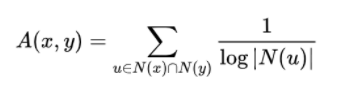

In [28]:
def compute_ADA(u,v, graph):
    """
    compute adamic-adar from scratch
    """
    
    # set of neighbors of u
    outlinks_from_u = set(graph.neighbors(u))

    # set of neighbors of v
    inlinks_to_v = set(graph.neighbors(v))

    
    # set Z of neighbors of both
    bridges =outlinks_from_u.intersection(inlinks_to_v)

    # degree of nodes in set Z
    deg_ = graph.degree(list(bridges))
    #deg_ =[graph.degree(n) for n in bridges]
    
    # computing the reciprocal in log-scale
    out = [1./np.log2(dd+1) for dd in deg_]

    return sum(out)

In [247]:
ADA_values = {}

for u, v in all_potential_recommendations:
  ADA_values[u] = compute_ADA(u,v, g)

In [248]:
from statistics import mean
average_ADA = mean(ADA_values[k] for k in ADA_values)

print('The average from ADA values obtained among the potential recommendations in graph is:\n', average_ADA )

The average from ADA values obtained among the potential recommendations in graph is:
 0.2800712353900169


Now we take the top 10 nodes with higher similarity inside the ADA output and see if they are contained in the test set.

In [175]:
ADA_recommended_values = sorted(ADA_values, key=ADA_values.get)[0:10]
print('The 10 edges with higher ADA value are the following:\n', ADA_recommended_values)

The 10 edges with higher ADA value are the following:
 [(10956, 14432), (28446, 1155), (23948, 18936), (5398, 25363), (25689, 9261), (5831, 746), (6869, 6316), (12258, 28699), (25245, 19561), (26354, 7697)]


### 3.2 - ALS
Classical matrix factorization algorithm used for implicit feedback.

As the potential recommendations were too much, we took the advice of reducing the number of samples. In order to do it we decomposed the graph and took one of the samples to work with it.

In [31]:
decomposed_g = Graph()
decomposed_g = g.decompose(mode=STRONG, maxcompno=1048576, minelements=32)

In [32]:
decomposed_g

As shown above, it was decomposed in 11 graphs, so we are taking a eleventh part of the initial graph.

In [33]:
# first we get the adjacency matrix data
M = decomposed_g[0].get_adjacency().data
M = csr_matrix(M)

In [34]:
# here we run the model ALS
model = implicit.als.AlternatingLeastSquares(factors=32, calculate_training_loss=True,  iterations=10)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(M)

In [35]:
model.item_factors.shape

(13691, 32)

**Test ALS**

As we sampled the graph, now we need to create again test and train set from this sample.

In [36]:
# fraction of edges to select as test-set
p_ALS = 0.2

# graphsize
N_ALS = len(decomposed_g[0].es)

# idxs of all the edges
all_idxs_ALS = range(N)

# sample idxs of edges through the function "choice"
test_idxs_ALS = np.random.choice(all_idxs_ALS, size=int(p_ALS*N_ALS), replace=False)

In [38]:
ground_truth_ALS = set()
trainset_ALS = set()
for idx, one_edge in enumerate(decomposed_g[0].es):
    
    # take n1 and n2 idx from one_edge, that is an igraph edge *object*
    n1 = one_edge.source
    n2 = one_edge.target

    if idx in test_idxs_ALS:
        
        ground_truth_ALS.add((n1, n2, 1))
    else:
        trainset_ALS.add((n1, n2, 1))

Then we implement the ALS prediction.

In [43]:
def predict_ALS(testset, model):
    """
    predict for a list of observations the score for adding/removing a link
    """

    # initialize the empty list
    all_predictions = []

    # scroll the obs
    for n1,n2, w in testset:
        
        # take here the low-dimensional vectors returned by the matrix factorization
        
        array_n1 = model.user_factors[n1]
        array_n2 = model.item_factors[n2]

        # multiplying these vectors we generate an approximation for the edge score
        one_p = np.dot(array_n1, array_n2)

        all_predictions.append(one_p)
        
    return all_predictions

In [46]:
# generate the predictions
df_test_ALS = pd.DataFrame(list(ground_truth_ALS), columns=["n1","n2", "edge"])
all_predictions = predict_ALS(df_test_ALS.values, model)

# add predictions to df
df_test_ALS["rating"] = all_predictions

# convert predictions to binary values: 0 don't add the edge, 1 add it.
df_test_ALS["rating"] = df_test_ALS["rating"].apply(lambda x: round(x))

In [48]:
# number of observations matched by the prediction
right_predictions = len(df_test_ALS[df_test_ALS.edge == df_test_ALS.rating])

# accuracy
right_predictions/len(df_test_ALS)

0.3875338753387534

### 3.3 - PageRank

In [61]:
execute = True
if execute:
  pagerank = {}

  for v in g.vs:
    pagerank[v] = g.pagerank(vertices = v)

In [62]:
np.max(pagerank)[0:10]

2.9232927970065482e-05

### 3.4 - Jaccard
As we were told to implement an algorithm seen during lessons we implemented the Jaccard coefficient.

In [65]:
def compute_Jaccard(u,v, graph):
    """
    compute jaccard similarity
    """
    

    # set of neighbors of u
    outlinks_from_u = set(graph.neighbors(u))

    # set of neighbors of v
    inlinks_to_v =set(graph.neighbors(v))

    # intesection of the two sets
    num =outlinks_from_u.intersection(inlinks_to_v)
    
    # union of the two sets
    den = outlinks_from_u.union(inlinks_to_v)
    
    # final division
    out = len(num)/len(den)
    
    return out

In [71]:
values_jaccard = {}

for u, v in all_potential_recommendations:
  values_jaccard[u] = compute_Jaccard(u,v, g)

## 4 - Top-10 list of Recommendations
For nodes in the test-set.

In [50]:
def print_top_k(graph, topk, opt, vid=None):
    """
    we print the top-k nodes with highest degree, pagerank and personalized-pagerank.
    
    Based on the selected option, a different top-k is generated
    """
    if opt == "degree":
        
        # degree and node-idx
        deg = enumerate(graph.degree())
        
        # sorting the list "deg" by degree, extracting the top-k
        out = sorted(deg, key=lambda tup: tup[1], reverse=True)[:topk]
    
    if opt == "pagerank":
        
        pr = enumerate(graph.pagerank())

        # sorting the list "pr" by pagerank, extracting the top-k

        out = sorted(pr, key=lambda tup: tup[1], reverse=True)[:topk]
        
    if opt == "personalized-pr":
        
        # here we need also the argument vid, which corresponds to a node-id
        pr = enumerate(graph.personalized_pagerank(reset_vertices=vid))

        out = sorted(pr, key=lambda tup: tup[1], reverse=True)[:topk]
        
    return out

In [51]:
print_top_k(g, 10, "pagerank")

[(16, 0.020605212973505566),
 (128, 0.014875022352678981),
 (24, 0.012282634806377197),
 (34, 0.005466551253901851),
 (12, 0.004703461244252258),
 (7, 0.003609175407203987),
 (78, 0.0033251228503103063),
 (500, 0.0032506223841624734),
 (111, 0.003013404512575519),
 (5, 0.002882298254750507)]

In [52]:
print_top_k(g, 10, "degree")

[(16, 1530),
 (128, 1015),
 (24, 799),
 (34, 357),
 (12, 313),
 (1872, 310),
 (78, 285),
 (500, 276),
 (1153, 256),
 (7, 231)]

##5 - NDCG

In [309]:
def dcg_at_k(y_true, y_score,  k=10):
    order = np.argsort(y_score)[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = sorted(y_true, key=y_true.get)[0:10]
    gain =  np.power(y_true,2) - 1# Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(y_true))+2)# Compute denominator
    return np.sum(gain / discounts) #return dcg@k

def ndcg_at_k(y_true, y_score, k=10):    
    dcg_max = dcg_at_k(y_true, y_true, k) # Ideal dcg
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(y_true, y_score, k)/dcg_max,4)

For ADA approach

In [312]:
q_id = 0
k = 10

ndcg_k = np.round(ndcg_at_k(ADA_values, test_idxs, k),4)
print("ndcg@{} for query with q_id={}: {}".format(k,q_id,ndcg_k))

ndcg@10 for query with q_id=10: 1.0


For Jaccard Approach

In [313]:
q_id = 0
k = 10

ndcg_k = np.round(ndcg_at_k(values_jaccard, test_idxs, k),4)
print("ndcg@{} for query with q_id={}: {}".format(k,q_id,ndcg_k))

ndcg@10 for query with q_id=0: 1.0
